# Stationary Equilibrium

In this notebook, I illustrate the solution to the **stationary equilibrium** for the housing model.

## Setup and Solve

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from HousingModel import HousingModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

In [2]:
# Something for figure layout here

Run the model for the first time here

In [3]:
# Define the model
model = HousingModelClass(name='example_negm',par={'solmethod':'negm', 'do_print':False})

# Solve and simulate
model.precompile_numba()
# model.solve()
# model.simulate()

In [4]:
model.par.ph = 1.0
model.solve()
model.simulate()

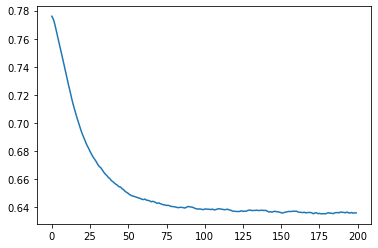

In [5]:
plt.plot(np.mean(model.sim.d, axis=1))

In [6]:
np.mean(model.sim.d[-1,:])

0.6360668936936261

In [7]:
Hs_true = np.mean(model.sim.d[-1,:])

Test how the model behaves for different parameter values in ss

[]

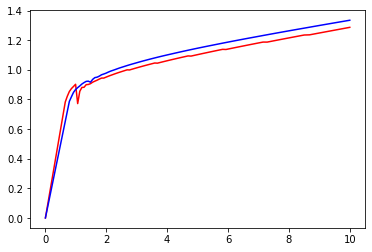

In [8]:
plt.plot(model.par.grid_m, model.sol.c_adj[0,0,1,:], linestyle = '-', color = 'red', linewidth = '1.5', label = r'$y=y_2$')
plt.plot(model.par.grid_m, model.sol.c_keep[0,0,1,0,:], linestyle = '-', color = 'blue', linewidth = '1.5', label = r'$y=y_2$')
plt.plot()

[]

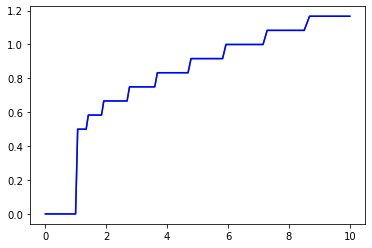

In [9]:
plt.plot(model.par.grid_m, model.sol.d_adj[0,0,1,:], linestyle = '-', linewidth = '1.5', label = r'$y=y_2$')
plt.plot(model.par.grid_m, model.sol.d_adj[0,0,1,:], linestyle = '-', color = 'blue', linewidth = '1.5', label = r'$y=y_2$')

plt.plot()

Check simulation

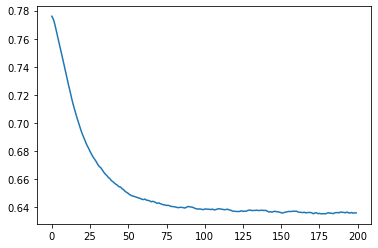

In [10]:
h_agg = np.mean(model.sim.d, axis=1)
plt.plot(h_agg)

# Find stationary equilibrium

Find demand curve over a grid of house prices

In [41]:
# Grid over house prices
Nr = 18
p_vec = np.linspace(0.5,1.5,Nr)
p_min = p_vec[0]
p_max = p_vec[Nr-1]

# Supply
Hs = 0.6360668936936261 # Find some value

# Initialize demand function
Hd = np.zeros(shape=len(p_vec))

# Loop
t0 = time.time()
for i_p,p in enumerate(p_vec):
    
    # Solve and simulate model
    model.par.ph = p
    model.solve()
    model.simulate()
    
    # Aggregate demand
    Hd[i_p] = np.mean(model.sim.d[-1,:])
    
    # Bound on p
    diff = Hs - Hd[i_p]
    if diff < 0: p_min = np.fmax(p_min, p_vec[i_p])
    if diff > 0: p_max = np.fmin(p_max, p_vec[i_p])
    
    # print(i_p)
    
t1 = time.time()

In [12]:
print(t1-t0)

140.061190366745


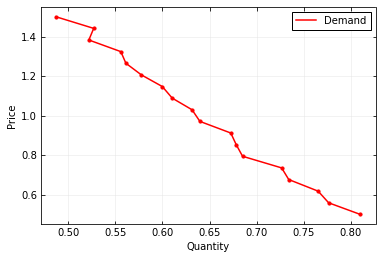

In [42]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Hd,p_vec, color = 'red', label = 'Demand',zorder=2)
ax.scatter(Hd,p_vec, color = 'red',zorder=3, marker='o', s=10)

# ax.vlines(Hs_true,0,10, color = 'blue', linestyle = '-', label ='Supply')
# ax.plot(Hd,supply, color = 'blue', linestyle = ':')

# ax.hlines(p_min,0,0.15, linestyle='--', color = '0.2', linewidth = 1)
# ax.hlines(p_max,0.0,0.15, linestyle='--', color = '0.2', linewidth = 1)

# ax.set_xlim(1.2,1.65)
# ax.set_ylim(0.4,1.6)
ax.set_xlabel('Quantity')
ax.set_ylabel('Price')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/equilibrium.pdf')

Last step

def obj(p,model):
    
    model.par.ph = p
    model.solve()
    model.simulate()
    return np.mean(model.sim.n[-1,:]) - Hs

t0 = time.time()

opt = optimize.root_scalar(obj,bracket=[p_min,p_max],method='bisect',args=(model,),maxiter=100)
model.par.ph = opt.root
assert opt.converged

t1 = time.time()
print(t1-t0)

print(opt)

## Plot Results

Plot the **policy functions** and **stationary distributions** from the model.
Also illustrate convergence of the distributions

In [94]:
# Solve and simulate the model
p = 2.0 # update this

model.par.ph = p
model.solve()
# model.simulate()

Traceback (most recent call last):
  File "C:\Users\madsh\OneDrive - University of Copenhagen\Desktop\Thesis\code\MA_thesis\HousingModel.py", line 341, in solve
    assert np.all((sol.q[t] > 0) & (np.isnan(sol.q[t]) == False)), t
AssertionError: 77


AssertionError: 77

### Plot the policy functions

Non-durable Consumption

In [ ]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,1,5,:], color = 'red', linewidth = '1.5', label = r'$y=y_2$')
ax.plot(model.par.grid_m, model.sol.c_keep[0,0,0,5,:], color = 'blue', linewidth = '1.5', label = r'$y=y_1$')

# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Consumption')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/c_keep.pdf')

In [ ]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_m, model.sol.c_adj[0,0,1,:], linestyle = '-', color = 'red', linewidth = '1.5', label = r'$y=y_2$')
ax.plot(model.par.grid_m, model.sol.c_adj[0,0,0,:], linestyle = '-', color = 'blue', linewidth = '1.5', label = r'$y=y_1$')

# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Consumption')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/c_adj.pdf')

Housing demand

In [ ]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_m, model.sol.d_adj[0,0,1,:], linestyle = '--', color = 'red', linewidth = '1.5', label = r'$y=y_2$')
ax.plot(model.par.grid_m, model.sol.d_adj[0,0,0,:], linestyle = ':', color = 'blue', linewidth = '1.5', label = r'$y=y_1$')

# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Housing Demand')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

# plt.savefig('../../tex/figs/h_adj.pdf')

## Plot Distributions

Wealth distribution

In [ ]:
# Define wealth
w = model.sim.a + model.par.ph*model.sim.d
# w = model.sim.m

# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(w[-1,:], bins = 80, density = True, edgecolor = 'k', zorder=2)

# Plot setting
ax.set_xlabel('Wealth $w$')
ax.set_ylabel('Density')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/w_distr.pdf')

Aggregate housing demand

In [ ]:
# Define wealth
w = model.sim.m + model.par.ph*model.sim.d

# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.hist(model.sim.n[-1,:], 40, density = True, facecolor='0.6', edgecolor = 'k', zorder=2)

# Plot setting
ax.set_xlabel('Housing $h$')
ax.set_ylabel('Density')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

plt.savefig('../../tex/figs/h_distr.pdf')

### Plot Convergence of Simulation 

Simulate a **longer time horizon** to check for convergence

In [ ]:
# Vector of aggregates
h_agg = np.mean(model.sim.d, axis=1)
n_agg = np.mean(model.sim.n, axis=1)
c_agg = np.mean(model.sim.c, axis=1)
m_agg = np.mean(model.sim.m, axis=1)
y_agg = np.mean(model.sim.y, axis=1)